<a href="https://www.kaggle.com/code/maita27/digit-recognizer?scriptVersionId=253840084" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [34]:
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [16]:
train.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [6]:
pixel_df = train.drop(columns = ['label'], inplace = False)

In [26]:
pixel_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#function to get all pixel values for a specific row
def get_row_pixels(df, row):
    pixel_values = []
    for column_nr in range(0, 784):
        pixel_values.append(df[f'pixel{column_nr}'][row])
    return pixel_values

#function to make a list of lists for every row in the df
def list_of_lists(df):
    processed_img_list = []
    for i in range(0, 42000):
        processed_img_list.append(get_row_pixels(df, i))
    return processed_img_list
                                  
imag = list_of_lists(pixel_df)

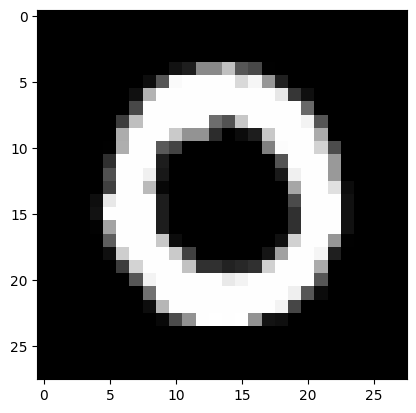

In [36]:
image_to_list = np.array(imag, dtype = 'float') #arraying it so we can mess around with dimensions
X_train = image_to_list.reshape(-1, 28, 28, 1) #defining x train as a 4D array
# -1 : letting numpy handle the first dimension
# 28 : height
# 28 : width
# 1 : one channel for grayscale image (3 for rgb)

plt.imshow(X_train[1].reshape(28, 28), cmap = 'gray') #plotting in grayscale reshaped to 2D(plt expects that)
plt.show()

In [39]:
y_train = list(train['label'])

In [43]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPool2D
from keras.layers import LeakyReLU

model = Sequential()

model.add(Conv2D(filters = 32,
                kernel_size = (5,5),
                padding = 'Same',
                input_shape = (28, 28, 1)))

model.add(LeakyReLU(alpha = 0.1))

model.add(Conv2D(filters = 32,
                kernel_size = (5,5),
                padding = 'Same'))

model.add(LeakyReLU(alpha = 0.1))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(BatchNormalization())




model.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 padding = 'Same'))

model.add(LeakyReLU(alpha = 0.1))

model.add(Conv2D(filters = 64,
                kernel_size = (3,3),
                padding = 'Same'))

model.add(LeakyReLU(alpha = 0.1))

model.add(MaxPool2D(pool_size = (2,2),
                   strides = (2,2)))

model.add(BatchNormalization())

model.add(Dropout(0.25))




model.add(Conv2D(filters = 128,
                kernel_size = (3,3),
                padding = 'Same'))

model.add(LeakyReLU(alpha = 0.1))

model.add(Conv2D(filters = 128,
                kernel_size = (3,3),
                padding = 'Same'))

model.add(LeakyReLU(alpha = 0.1))

model.add(MaxPool2D(pool_size = (2,2),
                   strides = (2,2)))

model.add(BatchNormalization())

model.add(Dropout(0.25))




model.add(Conv2D(filters = 256,
                kernel_size = (3,3),
                padding = 'Same'))

model.add(LeakyReLU(alpha = 0.1))
model.add(Conv2D(filters = 256,
                kernel_size = (3,3),
                padding = 'Same'))

model.add(LeakyReLU(alpha = 0.1))

model.add(MaxPool2D(pool_size = (2,2),
                    strides = (2,2)))

model.add(BatchNormalization())

model.add(Dropout(0.25))




model.add(Flatten())

model.add(Dense(512,
               activation = 'relu'))

model.add(Dense(30))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,337,470 (5.10 MB)

 Trainable params: 1,336,510 (5.10 MB)

 Non-trainable params: 960 (3.75 KB)

In [44]:
model.compile(optimizer ='adam', loss='mean_squared_error', metrics = ['mae'])

Version2:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F

In [ ]:
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [ ]:
print(df_train.shape)

In [ ]:
df_train.head()

In [ ]:
y_train = df_train['label'].values.astype(np.int64)
x_train = df_train.drop(columns = ['label']).values.astype(np.float32)

In [ ]:
plt.imshow(x_train[3].reshape(28, 28), cmap = 'gray')

In [ ]:
class DigitDataset(Dataset):
    def __init__(self, x_df, y_df):
        self.x = x_df.astype(np.float32)
        self.y = y_df.astype(np.int64)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        #get image and label
        image = self.x[idx].reshape(1, 28, 28)
        label = self.y[idx]
        return torch.tensor(image), torch.tensor(label)

In [ ]:
train_dataset = DigitDataset(x_train, y_train)

In [ ]:
#wrap dataset in a dataloader

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
#batch_size = how many sample the model looks at before updating its weights
#shuffle = mixing data randomply before each epochs

In [ ]:
#build a model

class SimpleNN(nn.Module): #SimpleNN inherits nn.Module
    def __init__(self):
        super().__init__() #inheritS the __init__ from nn.Nodule

        #nn.Linear(in_features, out_featres)
        
        self.fc1 = nn.Linear(28*28, 128) #input layer to hidden layer, 784 -> 128, so each of the 784 inputs connect to each 128 neurons
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1) #flatten the 1x28x28 images into 784 vector
        x = F.relu(self.fc1(x)) # relu activation
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # raw scores (logits)
        return x

In [ ]:
#instatiating model

model = SimpleNN()
criterion = nn.CrossEntropyLoss() #for multi-class classificatoin
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
#training loop

num_epochs = 5 #num of full passthroughs of training dataset

for epoch in range(num_epochs):
    model.train() #set model in training mode
    running_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad() #zero the gradients
        outputs = model(images) #forward pass
        loss = criterion(outputs, labels) #compute loss
        loss.backward() #backpropagation
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [ ]:
x_test = df_test.values.astype(np.float32)
x_test_tensor = torch.tensor(x_test).view(-1, 1, 28, 28)

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for i in range(0, len(x_test_tensor), 64): #64 = batch size
        batch = x_test_tensor[i:i+64]
        outputs = model(batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

In [ ]:
sub = pd.DataFrame({
    'ImageId':list(range(1, len(predictions) +1 )),
    'Label':predictions
})

sub.to_csv('submission.csv', index = False)